# CAB420 Metric Learning, Bonus Example: TFDS and Triplet Mining
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

If you're here, I am expecting that you've gone through the metric learning content, and have a pretty good idea of what is hapenning when we implelement a triplet loss. Hopefully, you'll also have worked through the prac (if not, stop reading this and go and do that). Having gone through the triplet network faff a few times, you might be a bit over it, and be of the opinion that the whole process of setting up your generator, building triplets, passing them through multiple branches, etc, is too much bother.

However, in a dramatic plot twist, it turns out that there is an easier way. Before you get all upset that we went through the other way first, please put your pitchfork down and keep in mind that:
* The other way is not that bad. You should see what it looks like in MATLAB for example. Really, it's pretty easy to set up a triplet loss.
* It's really important to understand what's going on with these metric learning methods, and what's actually being minimised by the training process. The approach we're going to explore here really hides of all the important stuff where we get distances between triplets, and seek to minmise that. So having an understanding of what's actually going on is important, as the code we're going to use here doesn't capture the underlying mechanics at all.

With that out the way, there are a few limitations of our previous triplet approaches that are worth highlighting:
* We have to generate all of our triplets in advance.
* Not all triplets are good learning examples. By that, I mean a lot of them are possibly very easy. They contain a positive pair that is very similar, and a negative image that is clearly very different. Ideally, we'd like triplets where things are a bit less obvious (if you're not certain about what I mean here, have a look at the "semi-hard and hard triplets" section below.
* It's not super efficient. We have to pass three images through the network to generate a single training example. In a batch of 128 triplets, 384 images go through the backbone. There's simply a lot of underutilisation there.
* The prior approach doesn't scale cleanly to large (i.e. cannot fit in memory) datasets. How would you integrate it with tfds for each to stream data into the model?

The solution to the above woes is to not create triplets - or at least to not create triplets at the input to the network. To explain this, consider a typical network like we've done (over and over again) for classification. Think about what a batch of that data looks like. We have $N$ samples, each of those samples has it's data, and a class label. Within that one batch of data, there may exist dozens, or hundreds, of potential triplets. So rather than pass triplets into the network, why not pass a batch of data through, get the embeddings, and then create a huge set of triplets? What's more, having created these triplets we could just keep the ones that are interesting for learning. This process is referred to as online triplet mining, and if you'd like a really good breakdown of how this is achieved in code, [this blog post](https://omoindrot.github.io/triplet-loss) is well worth a read. Here, we'll just the loss function in the tensorflow addons package to achieve our aims.

### Semi-Hard and Hard Triplets

Recall the triplet loss:

$L = max(d(p,a) - d(n,a) + margin, 0)$

where $d$ is some distance function, $a$ is the embedding for the anchor sample, $p$ is the embedding for the positive sample (i.e. the same class as the anchor), and $n$ is the embedding for the negative sample (different class to the anchor). The aim of the triplet loss is to make $d(p,a)$ as close to 0 as possible, and ensure that $d(n,a)$ is equal to $d(p,a) + margin$, or more.

As we start to train a network, we can end up with three types of triplets:
* Easy Triplets. These are ones where the loss is 0, i.e. $d(p,a) + margin < d(n,a)$. As the loss for these is 0, there's nothing more than we can learn from these.
* Semi-Hard Triplets. These are ones where $d(p,a) < d(n,a) < d(p,a) + margin$, i.e. our positive and anchor pair are closer together than the negative and anchor, but the gap between them isn't quite as big as we'd like.
* Hard Triplets. These are the ones that are flat out wrong, $d(n,a) < d(p,a)$, i.e. the negative pair is closer together than the positive pair.

The first kind of triplets are not going to give us a useful signal for the learning, only the second and third types will.

### Where does this fit into all the other CAB420 content?

This example is a bit of theoretical/conceptual extension to the metric learning content, but has the added benefit of greatly simplifying the code you need to write. Like the other TFDS example from earlier, I expect this will be of most use for Assignment 2 (but you may also want to use this elsewhere).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.manifold import TSNE

### Data

I'm going to use tfds here, and I'll pull fashion MNIST down through that. I'll stick to fashion MNIST for consistency, despite the temptation to play with other random things.

We'll then use the tfds pipeline to set up our augmentation. This will make training with augmented data much easier than it otherwise may have been if we stuck to the offline triplet mining approach that used in the main examples.

The process here is very much like that that was used in the bonus tfds example. If this is unclear, go and have a look over there.

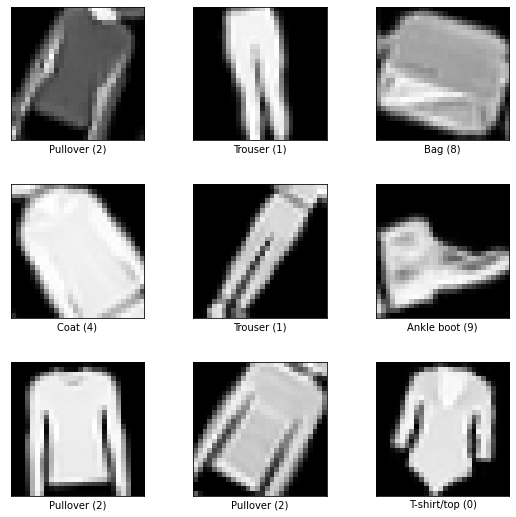

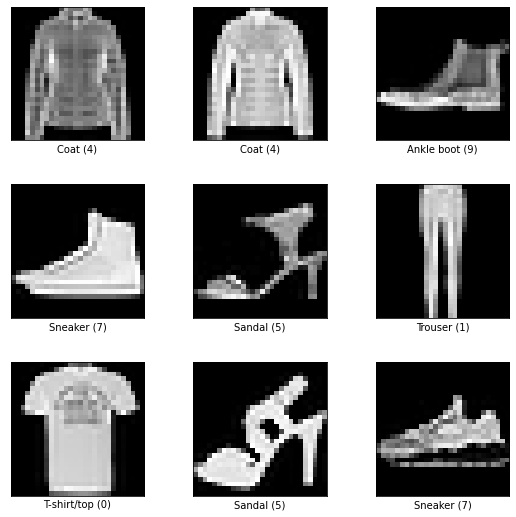

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load('fashionMNIST',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

# rescaling operation. No resizing here as we already have small images (32x32)
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

# augmentation operations
augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom((-0.1, 0.1)),
])

# function to apply rescaling and augmentation (if wanted)
def prepare_ds(ds, augment=False):

    # apply preprocessing (resizing and rescale)
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if requested
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return ds

# function to apply batching and prefecting
# This could very easily be part of the "prepare_ds" function, but you can't call show exmaples
# on batched data
def batch_and_prefetch(ds):       
    # batch the dataset
    ds = ds.batch(batch_size)
    
    # use buffered prefetching
    return ds.prefetch(buffer_size=AUTOTUNE)

# Use augmentation for training data only
ds_train = prepare_ds(ds_train, True)
ds_val = prepare_ds(ds_val, False)
ds_test = prepare_ds(ds_test, False)

# show examples, should have augmentation visible in the training data, but not the
# testing data
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

# batch and pre-fetch
ds_train = batch_and_prefetch(ds_train)
ds_val = batch_and_prefetch(ds_val)
ds_test = batch_and_prefetch(ds_test)

### The Network

For consistency (and because copy/paste saves time), I will use the same basic network that I've used in the main metric learning examples. There is one change though: the normalisation operation now exists as the last layer in the network. This will live here rather than in our custom loss function.

In [3]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
embedding_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding_layer)
base_network = keras.Model(dummy_input, embedding_layer)

base_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 8)         0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 28, 28, 8)        0         
 ropout2D)                                                   

### Training the Network

And now we can compile and train the network. There is no creation of triplets, no custom loss functions (well, aside from the one in tensorflow-addons) - it's just like a regular network.

In [4]:
base_network.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())
history = base_network.fit(ds_train, epochs=10, validation_data = ds_val)

Epoch 1/10
422/422 [==============================] - 60s 127ms/step - loss: 0.8634 - val_loss: 0.7464
Epoch 2/10
422/422 [==============================] - 72s 170ms/step - loss: 0.7668 - val_loss: 0.6878
Epoch 3/10
422/422 [==============================] - 91s 216ms/step - loss: 0.7294 - val_loss: 0.6670
Epoch 4/10
422/422 [==============================] - 97s 230ms/step - loss: 0.7026 - val_loss: 0.6231
Epoch 5/10
422/422 [==============================] - 92s 217ms/step - loss: 0.6847 - val_loss: 0.6230
Epoch 6/10
422/422 [==============================] - 91s 216ms/step - loss: 0.6677 - val_loss: 0.5929
Epoch 7/10
422/422 [==============================] - 87s 207ms/step - loss: 0.6563 - val_loss: 0.5831
Epoch 8/10
422/422 [==============================] - 82s 193ms/step - loss: 0.6440 - val_loss: 0.5861
Epoch 9/10
422/422 [==============================] - 81s 191ms/step - loss: 0.6363 - val_loss: 0.5952
Epoch 10/10
422/422 [==============================] - 77s 182ms/step - l

From the above, it appears that the network has barely learnt anything, the loss values aren't really dropping much at all - at least not compared to what we're used to. But this is not really giving us a complete view of what's going on. Our online triplet mining process will be removing from consideration any triplet that is easy (while also removing any triplet that is hard). As such, we don't have all of these triplets with a loss of 0 in there pulling our loss function down. Any triplet that is being used is giving us useful information. 

Looking at our resulting embeddings, we can see that we've got some pretty good results going on.

/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


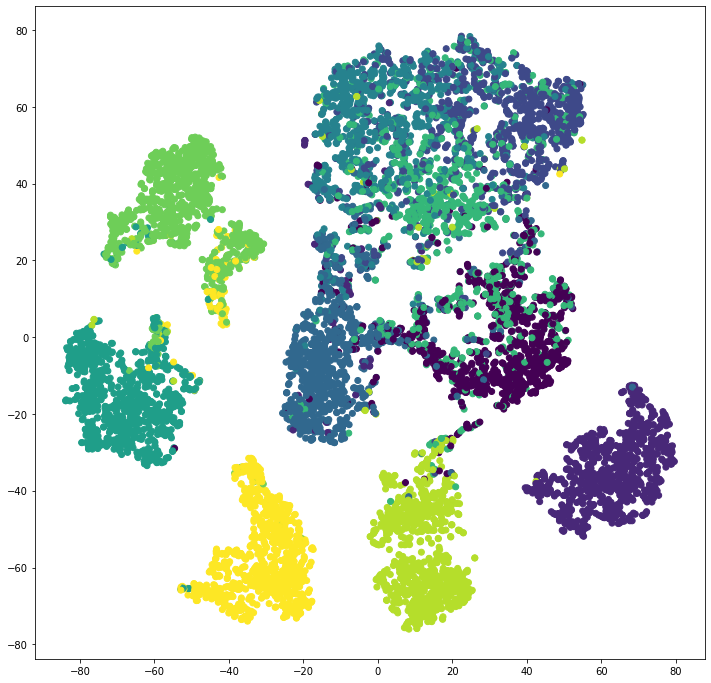

In [5]:
y_test = tf.concat([y for x, y in ds_test], axis=0)
embeddings = base_network.predict(ds_test, verbose=False)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

### Hard Triplets

Because we can, we'll now rinse and repeat with the hard triplets.

In [6]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
embedding_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding_layer)
base_network = keras.Model(dummy_input, embedding_layer)

base_network.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletHardLoss())
history = base_network.fit(ds_train, epochs=10, validation_data = ds_val)

Epoch 1/10
422/422 [==============================] - 80s 186ms/step - loss: 1.0624 - val_loss: 1.0146
Epoch 2/10
422/422 [==============================] - 79s 186ms/step - loss: 1.0088 - val_loss: 1.0056
Epoch 3/10
422/422 [==============================] - 80s 189ms/step - loss: 1.0048 - val_loss: 1.0033
Epoch 4/10
422/422 [==============================] - 79s 187ms/step - loss: 1.0034 - val_loss: 1.0031
Epoch 5/10
422/422 [==============================] - 79s 187ms/step - loss: 1.0028 - val_loss: 1.0025
Epoch 6/10
422/422 [==============================] - 84s 199ms/step - loss: 1.0023 - val_loss: 1.0020
Epoch 7/10
422/422 [==============================] - 106s 250ms/step - loss: 1.0020 - val_loss: 1.0017
Epoch 8/10
422/422 [==============================] - 120s 283ms/step - loss: 1.0018 - val_loss: 1.0015
Epoch 9/10
422/422 [==============================] - 89s 211ms/step - loss: 1.0017 - val_loss: 1.0017
Epoch 10/10
422/422 [==============================] - 79s 186ms/step -

Here, we see larger loss values than we had above. This is not a problem, this is expected. Our network is now looking for the hardest triplets to use in training. All of the triplets that we are using will have a negative pair distance, $d(n,a)$, smaller than the positive pair distance, $d(p,a)$. This means that our loss will always be above 1.

/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


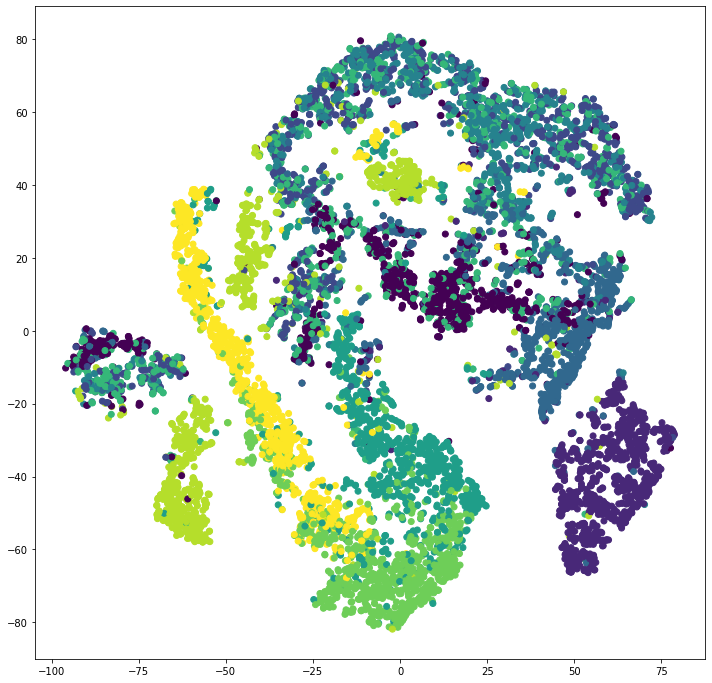

In [7]:
embeddings = base_network.predict(ds_test, verbose=False)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

Again, we see this working pretty well.

## Final Thoughts

Neither of the above changes to our loss have made things perfect, though that wasn't the aim here. Also, if we really want perfection we need a bigger network and longer training time.

What you hopefully have seen from the above is that we can actually do the whole metric learning thing really easily by thinking carefully about where we place the triplet generation process. By actually creating the triplets in the loss function, the entire process becomes much simpler (though the loss function get's a bit more interesting). [This blog post](https://omoindrot.github.io/triplet-loss) has an excellent discussion of what a loss function for online triplet mining looks like, and if you're interested it's well worth a look to understand how this is done.